In [1]:
import pickle
import gensim
import pyLDAvis
import pyLDAvis.gensim
import spacy
import pandas as pd
import nltk; nltk.download('stopwords')
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import re
import warnings
from pprint import pprint
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt

/Users/tendulkar/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tendulkar/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
import os
data_filepath = os.path.join(".","data")
print(data_filepath)

./data


# Preprocess

In [49]:
import pandas as pd
import json

In [37]:
#attributes	business_id	categories	city	name	biz_stars	state	date	review_stars	text	useful	real_counts	text_len	target

1. select business file 

In [45]:
data_directory = os.path.join('.','yelp_dataset')
review_filepath = os.path.join(data_directory,'review.json')

businesses_filepath = os.path.join(data_directory, 'business.json')

In [59]:
# Convert business json file into Dataframe
business_ids={}
business_ids["business_id"]=[]
business_ids["attributes"]=[]
business_ids["categories"]=[]
business_ids["city"]=[]
business_ids["name"]=[]
business_ids["biz_stars"]=[]
business_ids["state"]=[]

with open(businesses_filepath) as f:
    
    for business_record in f:
        business = json.loads(business_record)
        
        if not business.get('categories'):
            continue
        
        if 'Restaurants' not in business['categories']:
            continue
            

        business_ids["business_id"].append(business['business_id'])
        business_ids["attributes"].append(business['attributes'])
        business_ids["categories"].append(business['categories'])
        business_ids["city"].append(business['city'])
        business_ids["name"].append(business['name'])
        business_ids["biz_stars"].append(business['stars'])
        business_ids["state"].append(business['state'])

In [75]:
business_df= pd.DataFrame(business_ids)

In [76]:
# Convert reviews json file into Dataframe
execute = False

if execute:

    reviews_ids={}
    reviews_ids["business_id"]=[]
    reviews_ids["date"]=[]
    reviews_ids["review_stars"]=[]
    reviews_ids["text"]=[]
    reviews_ids["useful"]=[]
    review_count=0

    with open(review_filepath) as f:

        for reviews_record in f:
            review = json.loads(reviews_record)

            if review['business_id'] not in business_ids["business_id"]:
                continue


            reviews_ids["business_id"].append(review['business_id'])
            reviews_ids["date"].append(review['date'])
            reviews_ids["review_stars"].append(review['stars'])
            reviews_ids["text"].append(review['text'])
            reviews_ids["useful"].append(review['useful'])

            review_count+=1

In [74]:
reviews_df = pd.DataFrame(reviews_ids)

In [79]:
with open(os.path.join(data_filepath,'reviews_df.pkl'), 'wb') as f:
    pickle.dump(reviews_df, f)
    
with open(os.path.join(data_filepath,'business_df.pkl'), 'wb') as f:
    pickle.dump(business_df, f)

In [107]:
with open(os.path.join(data_filepath,'reviews_df.pkl'), 'rb') as f:
    reviews_df = pickle.load(f)
    
with open(os.path.join(data_filepath,'business_df.pkl'), 'rb') as f:
    business_df = pickle.load(f)

In [108]:
#Select only 10,000 reviews
reviews_df = reviews_df[:10000]
test_df = reviews_df[10001:11000]

In [109]:
reviews_df = reviews_df.merge(business_df,on="business_id",how="left")

In [110]:
reviews_count_per_business = reviews_df.groupby("business_id")["text"].agg('count')
reviews_count_per_business = reviews_count_per_business.rename('real_counts')

In [111]:
reviews_df = reviews_df.merge(reviews_count_per_business,on="business_id",how="left")

In [114]:
rev_train = reviews_df
rev_test = test_df

In [115]:
rev_train['text_len'] = rev_train['text'].apply(lambda x: len(x.split()))

#### Review Length by Star Count Distribution

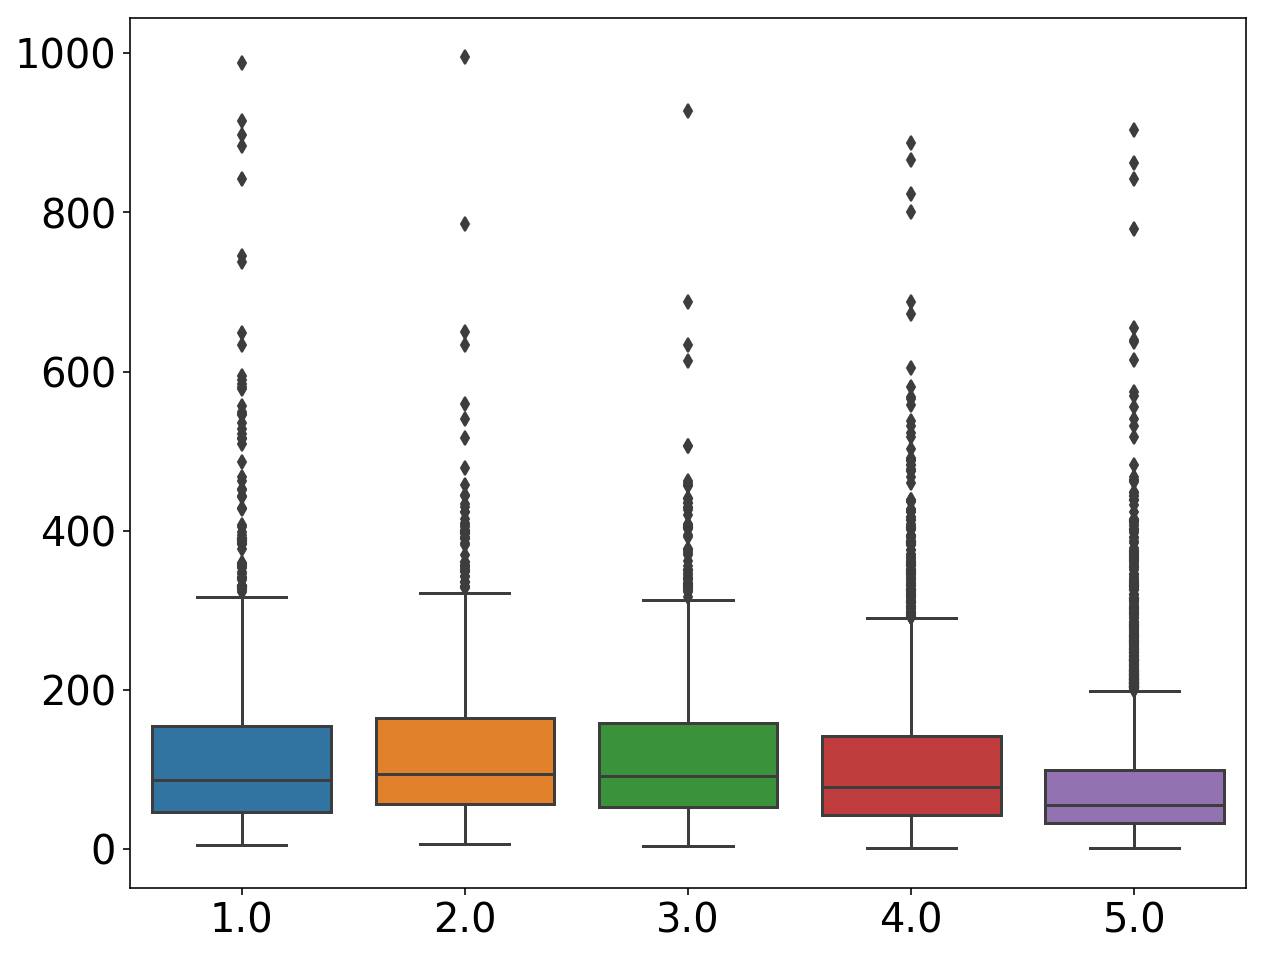

In [116]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 20})
sns.boxplot(x = 'review_stars', y = 'text_len', data = rev_train)
plt.ylabel('')
plt.xlabel('');

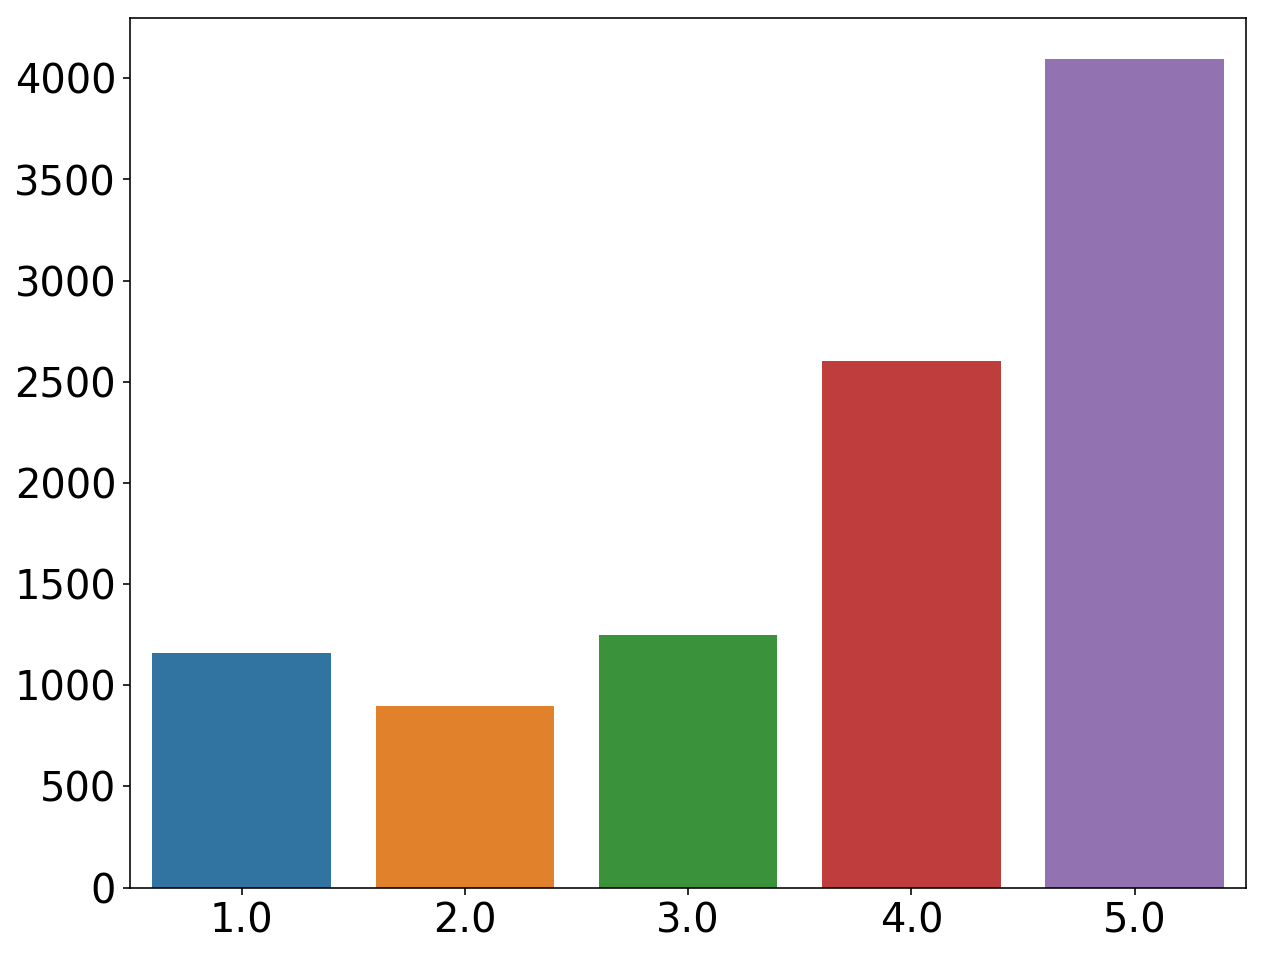

In [117]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 20})
sns.countplot('review_stars', data = rev_train)
plt.ylabel('')
plt.xlabel('');

#### Get Rid of Neutral Stars and Code Positive and Negative as Binary

In [118]:
rev_train = rev_train[rev_train.review_stars != 3.0]

In [119]:
rev_train['target'] = rev_train.review_stars.apply(lambda x: 1 if x > 3 else 0)

/Users/tendulkar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [120]:
print(len(rev_train))
mask = (rev_train['text'].str.len() > 50) & (rev_train['text'].str.len() < 200)
rev_train = rev_train.loc[mask]
print(len(rev_train))

8754
2025


In [121]:
rev_train.head()

,business_id,date,review_stars,text,useful,attributes,categories,city,name,biz_stars,state,real_counts,text_len,target
9,d4qwVw4PcN-_2mK2o1Ro1g,2015-02-02 06:28:00,1.0,10pm on a super bowl Sunday and they're alread...,0,"{'RestaurantsTakeOut': 'True', 'BusinessAccept...","Mexican, Restaurants",Las Vegas,Pink Taco,3.5,NV,28,19,0
12,d4qwVw4PcN-_2mK2o1Ro1g,2017-02-09 04:25:03,5.0,Holy heck this place is amazing. I love their ...,0,"{'RestaurantsTakeOut': 'True', 'BusinessAccept...","Mexican, Restaurants",Las Vegas,Pink Taco,3.5,NV,28,24,1
16,d_q4avZYM1sOlQP7noJKVg,2018-04-15 11:13:11,4.0,Always a fun outing to come for great hot dogs...,0,"{'GoodForKids': 'True', 'BusinessAcceptsCredit...","Mexican, Restaurants, Hot Dogs",Phoenix,El Güero Canelo,3.5,AZ,8,30,1
17,wkzWdo1mBqbzR2KPoXtWZw,2010-08-21 01:19:17,4.0,Was a Chicago style deep dish. Homemade type ...,1,"{'Caters': 'True', 'HasTV': 'True', 'Restauran...","Sandwiches, Chicken Wings, Pizza, Restaurants",Glendale,Vito's Pizza,4.0,AZ,3,26,1
18,r4HkiC71nB9k8Fe8zIORFQ,2015-12-05 02:16:06,5.0,First time eating there and everything was so ...,1,"{'BikeParking': 'True', 'Alcohol': 'u'beer_and...","Italian, Restaurants, Food Delivery Services, ...",Goodyear,Sal's Tuscan Grill,4.0,AZ,5,34,1


#### Prep Review Text for LDA

In [122]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['come','order','try','go','get','make','drink','plate','dish','restaurant','place',
                  'would','really','like','great','service','came','got'])

In [123]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [124]:
def strip_newline(series):
    return [review.replace('\n','') for review in series]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [125]:
def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

In [126]:
def get_corpus(df):
    """
    Get Bigram Model, Corpus, id2word mapping
    """
    
    df['text'] = strip_newline(df.text)
    words = list(sent_to_words(df.text))
    words = remove_stopwords(words)
    bigram = bigrams(words)
    bigram = [bigram[review] for review in words]
#     lemma = lemmatization(bigram)
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

In [127]:
train_corpus4, train_id2word4, bigram_train4 = get_corpus(rev_train)

In [128]:
bigram_train4[0]

['pm',
 'super',
 'bowl',
 'sunday',
 'already',
 'closed',
 'weak',
 'wonder',
 'hard',
 'rock',
 'dying']

In [129]:
with open(os.path.join(data_filepath,'train_corpus4.pkl'), 'wb') as f:
    pickle.dump(train_corpus4, f)
with open(os.path.join(data_filepath,'train_id2word4.pkl'), 'wb') as f:
    pickle.dump(train_id2word4, f)
with open(os.path.join(data_filepath,'bigram_train4.pkl'), 'wb') as f:
    pickle.dump(bigram_train4, f)
# with open('lemma_train.pkl', 'wb') as f:
#     pickle.dump(lemma_train, f)

In [130]:
# make sure importing right model
lda_train4 = gensim.models.ldamulticore.LdaMulticore.load('lda_train4.model')

In [131]:
with open(os.path.join(data_filepath,'train_corpus4.pkl'), 'rb') as f:
    train_corpus4 = pickle.load(f)
with open(os.path.join(data_filepath,'train_id2word4.pkl'), 'rb') as f:
    train_id2word4 = pickle.load(f)
with open(os.path.join(data_filepath,'bigram_train4.pkl'), 'rb') as f:
    bigram_train4 = pickle.load(f)
# with open('lemma_train.pkl', 'rb') as f:
#     lemma_train = pickle.load(f)

#### LDA Model in Gensim

In [132]:
import logging
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_train4 = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus4,
                           num_topics=20,
                           id2word=train_id2word4,
                           chunksize=100,
                           workers=7, # Num. Processing Cores - 1
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)
    lda_train4.save('lda_train4.model')

#### Example of Topics

In [133]:
lda_train4.print_topics(20,num_words=15)[:10]

[(0,
  '0.175*"pizza" + 0.051*"taste" + 0.047*"good" + 0.045*"cheese" + 0.035*"delivery" + 0.031*"thing" + 0.029*"recommended" + 0.028*"la" + 0.025*"bad" + 0.023*"beer" + 0.023*"ordered" + 0.022*"think" + 0.020*"also" + 0.019*"fan" + 0.019*"highly"'),
 (1,
  '0.056*"price" + 0.046*"pho" + 0.043*"well" + 0.042*"beef" + 0.038*"worth" + 0.037*"soup" + 0.034*"bbq" + 0.034*"awesome" + 0.033*"pork" + 0.032*"visit" + 0.031*"rice" + 0.029*"love" + 0.028*"korean" + 0.026*"delicious" + 0.023*"noodles"'),
 (2,
  '0.087*"good" + 0.082*"nice" + 0.068*"people" + 0.053*"wings" + 0.050*"prices" + 0.031*"ice_cream" + 0.031*"back" + 0.026*"lot" + 0.024*"decor" + 0.024*"average" + 0.022*"thai" + 0.022*"nothing" + 0.020*"friendly" + 0.020*"bar" + 0.018*"want"'),
 (3,
  '0.267*"best" + 0.111*"ever" + 0.038*"town" + 0.036*"far" + 0.035*"amazing" + 0.029*"one_best" + 0.025*"fun" + 0.020*"hands" + 0.018*"atmosphere" + 0.018*"style" + 0.017*"wow" + 0.017*"say" + 0.015*"mexican" + 0.015*"first" + 0.014*"vegas"'

### Make Vectors

In [134]:
train_vecs = []
for i in range(len(rev_train)):
    top_topics = lda_train4.get_document_topics(train_corpus4[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(20)]
    topic_vec.extend([rev_train.iloc[i].real_counts]) # counts of reviews for restaurant
    topic_vec.extend([len(rev_train.iloc[i].text)]) # length review
    train_vecs.append(topic_vec)

In [135]:
train_vecs[2]

[0.005000157,
 0.005000157,
 0.005000157,
 0.2153789,
 0.294614,
 0.005000157,
 0.005000157,
 0.005000157,
 0.005000157,
 0.005000157,
 0.105001874,
 0.0050001577,
 0.11022874,
 0.005000157,
 0.005000157,
 0.005000157,
 0.005000157,
 0.19977412,
 0.005000157,
 0.005000157,
 8,
 146]

#### Sklearn

In [136]:
X = np.array(train_vecs)

In [137]:
y = np.array(rev_train.target)

In [138]:
with open('y.pkl', 'wb') as f:
    pickle.dump(y, f)


In [139]:
with open('X.pkl', 'wb') as f:
    pickle.dump(X, f)

#### Final 5-fold CV

In [141]:
kf = KFold(5, shuffle=True, random_state=42)
cv_lr_f1, cv_lrsgd_f1, cv_svcsgd_f1,  = [], [], []

for train_ind, val_ind in kf.split(X, y):
    # Assign CV IDX
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind]
    
    # Scale Data
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_val_scale = scaler.transform(X_val)

    # Logisitic Regression
    lr = LogisticRegression(
        class_weight= 'balanced',
        solver='newton-cg',
        fit_intercept=True
    ).fit(X_train_scale, y_train)

    y_pred = lr.predict(X_val_scale)
    cv_lr_f1.append(f1_score(y_val, y_pred, average='binary'))
    
    # Logistic Regression Mini-Batch SGD
    sgd = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        loss='log',
        class_weight='balanced'
    ).fit(X_train_scale, y_train)
    
    y_pred = sgd.predict(X_val_scale)
    cv_lrsgd_f1.append(f1_score(y_val, y_pred, average='binary'))
    
    # SGD Modified Huber
    sgd_huber = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        alpha=20,
        loss='modified_huber',
        class_weight='balanced'
    ).fit(X_train_scale, y_train)
    
    y_pred = sgd_huber.predict(X_val_scale)
    cv_svcsgd_f1.append(f1_score(y_val, y_pred, average='binary'))

print(f'Logistic Regression Val f1: {np.mean(cv_lr_f1):.3f} +- {np.std(cv_lr_f1):.3f}')
print(f'Logisitic Regression SGD Val f1: {np.mean(cv_lrsgd_f1):.3f} +- {np.std(cv_lrsgd_f1):.3f}')
print(f'SVM Huber Val f1: {np.mean(cv_svcsgd_f1):.3f} +- {np.std(cv_svcsgd_f1):.3f}')

Logistic Regression Val f1: 0.798 +- 0.013
Logisitic Regression SGD Val f1: 0.755 +- 0.077
SVM Huber Val f1: 0.546 +- 0.446


/Users/tendulkar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tendulkar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
